In [2]:
from keras.layers import Input, Dense
from keras.models import Model

from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard, EarlyStopping
import utilities

from evaluator import Evaluator
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import matplotlib
import umap


from sklearn.ensemble import RandomForestRegressor

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

## Load data

In [11]:
x_train,y_train,x_test,y_test = load_MINST(1000,1000)

### model 1 

In [12]:
autoencoder,encoder = generate_deep_autoencoder()
er = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                validation_split=0.2,
                verbose=False,
                callbacks=[er])

print(autoencoder.evaluate(x_test,x_test))
print("stopped epoch: "+ str(er.stopped_epoch))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
1000/1000 [==============================] - 0s 77us/step
0.2743144173622131
stopped epoch: 26


In [20]:
emb_train = encoder.predict(x_train)
emb_test = encoder.predict(x_test)

evaluate(emb_test,y_test,emb_train,y_train)

DIM: 32             TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy    0.29    0.363


In [21]:
res_2d_test, res_2d_train = from_emb_to_2D(emb_train,y_train,emb_test)

evaluate(res_2d_test,y_test,res_2d_train,y_train)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy    0.16     0.48


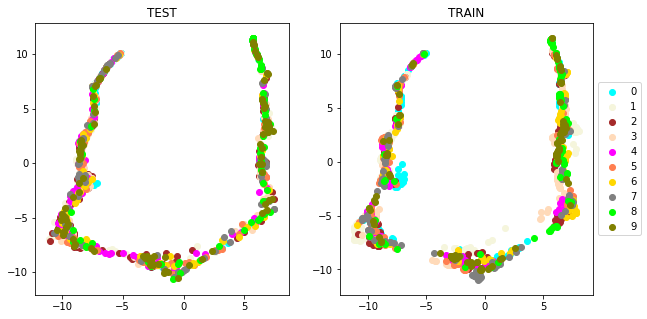

In [22]:
plot_embedding(res_2d_test,y_test,res_2d_train,y_train)

### model 2

In [23]:
import keras.backend.tensorflow_backend as K
count = 0

In [24]:
w_dec = K.variable(1)
w_cla = K.variable(1)

autoencoder,encoder = generate_supervised_autoencoder_callback(w_dec,w_cla,embedding_size=20)
count = count + 1

In [25]:
#path = "test_MINST/esperimento_00000"+str(count)
#tb = TensorBoard(log_dir=path)

epochs = 200
scaler = 50
my = MyCallback_low_high(w_dec,w_cla,epochs,l_period=10)

h = autoencoder.fit(x_train,
                    {'decoder': x_train, 'classifier': y_train},
                    epochs=epochs,  
                    batch_size=256,
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[my])

a = autoencoder.evaluate(x_train,[x_train,y_train])
n = autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

1000/1000 [==============================] - 0s 47us/step
loss 0.15281044449098408
decoder_loss 0.05409641519188881
classifier_loss 0.15281044449098408
decoder_mean_squared_error 0.05409641519188881
classifier_acc 0.973


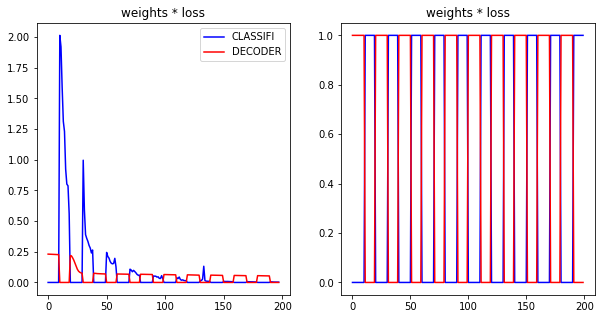

In [26]:
plot_loss(my,h)

DIM: 20             TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.853    0.957
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.712    0.976


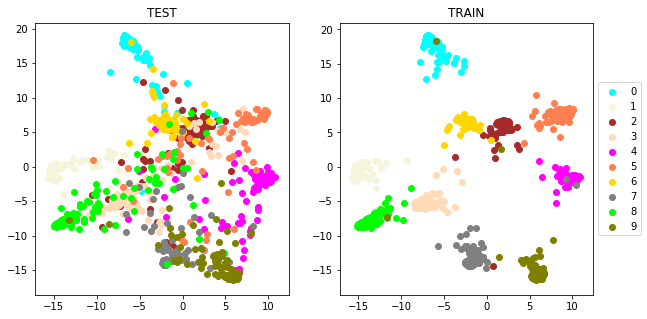

In [27]:
emb_train = encoder.predict(x_train)
emb_test = encoder.predict(x_test)
evaluate(emb_test,y_test,emb_train,y_train)


res_2d_test, res_2d_train = from_emb_to_2D(emb_train,y_train,emb_test)
evaluate(res_2d_test,y_test,res_2d_train,y_train)

plot_embedding(res_2d_test,y_test,res_2d_train,y_train)

### model 3

In [314]:
#path = "test_MINST/esperimento_00000"+str(count)
#tb = TensorBoard(log_dir=path)
w_dec = K.variable(1)
w_cla = K.variable(1)

autoencoder,encoder = generate_supervised_autoencoder_callback(w_dec,w_cla,embedding_size=15)

epochs = 200
plateau = 5
k = 1
n_period = 5

scale_c = 0.2
scale_d = np.linspace(1,3,epochs)

my = MyCallback_sinusoidal(w_dec,w_cla,epochs,plateau,k,n_period,scale_c,scale_d)

h = autoencoder.fit(x_train,
                    {'decoder': x_train, 'classifier': y_train},
                    epochs=epochs,  
                    batch_size=256,
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[my])

a = autoencoder.evaluate(x_train,[x_train,y_train])
n = autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

1000/1000 [==============================] - 0s 93us/step
loss 0.08979404711723328
decoder_loss 0.04820644325017929
classifier_loss 0.1748438190072775
decoder_mean_squared_error 0.04820644325017929
classifier_acc 0.97


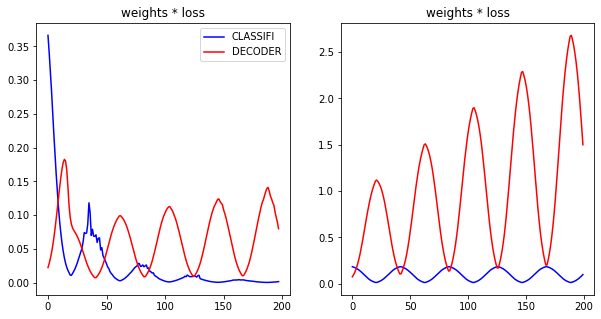

In [315]:
plot_loss(my,h)

DIM: 15             TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.843    0.929
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy    0.71    0.968


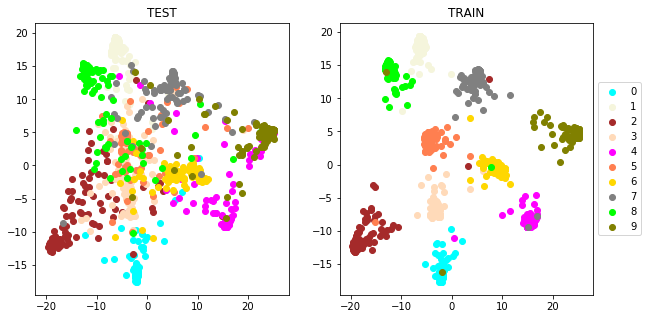

In [316]:
emb_train = encoder.predict(x_train)
emb_test = encoder.predict(x_test)
evaluate(emb_test,y_test,emb_train,y_train)


res_2d_test, res_2d_train = from_emb_to_2D(emb_train,y_train,emb_test)
evaluate(res_2d_test,y_test,res_2d_train,y_train)

plot_embedding(res_2d_test,y_test,res_2d_train,y_train)

In [245]:
import keras.backend.tensorflow_backend as K
from keras import callbacks
import math

class MyCallback_sinusoidal(callbacks.Callback):
    def __init__(self, w_dec, w_cla, n_epoch,plateau,k,n_period,scale_c,scale_d):
        
        self.n_epoch = n_epoch
        self.w_dec = w_dec
        self.w_cla = w_cla
        
        self.w_clas = []
        self.w_decs = []
        
        if (isinstance(scale_c,(int,float))):
            scale_c = np.ones(n_epoch)*scale_c
        
        if (isinstance(scale_d,(int,float))):
            scale_d = np.ones(n_epoch)*scale_d
            
        self.scale_c = scale_c
        self.scale_d = scale_d
        
        self.sigmoid = gen_sigm_seq(plateau,k,n_epoch,n_period)
        
        
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.w_cla, (-self.sigmoid[epoch]+1)*self.scale_c[epoch])
        K.set_value(self.w_dec, (self.sigmoid[epoch])*self.scale_d[epoch])

            
        self.w_decs.append(K.get_value(self.w_dec))
        self.w_clas.append(K.get_value(self.w_cla))
            

            

In [210]:
def gen_sigm_seq(plateau,k,epoche,period):
    
    points = int(epoche/(2*period))+1
    res = []
    for i in range(period):
        pos = gen_bell(plateau,k,points,True)
        res = res + pos

    return(res)
        
def gen_bell(plateau,k,points,sign):
    
    fir = gen_sigm(plateau,k,points,sign)
    sec = gen_sigm(plateau,k,points,not sign)

    return (fir+sec)
    
    

def gen_sigm(plateau,k,points,sign):
    samples = np.linspace(-plateau/2,plateau/2,points)

    res = []
    for i in samples:
        y = 1/(1+math.pow(math.e,-k*i))
        if (sign==False):
            res.append(-y +1 )    
        else:
            res.append(y)
    return(list(res))

In [4]:
from keras import callbacks
import math

class MyCallback_low_high(callbacks.Callback):
    def __init__(self, w_dec, w_cla, n_epoch,l_period):
        
        self.n_epoch = n_epoch
        self.w_dec = w_dec
        self.w_cla = w_cla
        
        self.w_clas = []
        self.w_decs = []
        
        self.l_period = l_period * 2
        self.current = 0
        
    def on_epoch_end(self, epoch, logs={}):
        
        if (self.current <= (self.l_period/2)):
            self.current = self.current + 1
            K.set_value(self.w_cla, 0)
            K.set_value(self.w_dec, 1)
        else:
            self.current = self.current + 1
            K.set_value(self.w_cla, 1)
            K.set_value(self.w_dec, 0)
            
        if (self.current == self.l_period):
            self.current = 0

            
        self.w_decs.append(K.get_value(self.w_dec))
        self.w_clas.append(K.get_value(self.w_cla))

In [5]:
from keras import backend as K

def generate_supervised_autoencoder_callback(w_dec,w_cla,embedding_size=32):

    input_img = Input(shape=(784,))
    enc = Dense(128, activation='relu')(input_img)
    enc = Dense(64, activation='relu')(enc)
    enc = Dense(embedding_size, activation='relu')(enc)

    dec = Dense(64, activation='relu')(enc)
    dec = Dense(128, activation='relu')(dec)
    dec = Dense(784, activation='sigmoid',name="decoder")(dec)


    cla = Dense(10,name="classifier",activation='softmax')(enc)

    autoencoder = Model(inputs=input_img,outputs=[dec,cla])
    encoder = Model(input_img,enc)

    autoencoder.compile(optimizer='adadelta', metrics={'decoder': 'mse', 'classifier': ['acc']},
                        loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                        loss_weights = {'decoder': w_dec, 'classifier': w_cla})
    return(autoencoder,encoder)

In [6]:

def plot_embedding(res_uma_test,y_test,res_uma_train, y_train):
    color_names = ["aqua", "beige", "brown", "peachpuff", "fuchsia","coral","gold","gray","lime","olive"]
    f = plt.figure(figsize=(10,5))

    
    tmp_y = utilities.from_one_hot_to_np(y_test)
    group = [ [] for x in range(10)]
    for i in range(len(tmp_y)):
        group[tmp_y[i]].append(res_uma_test[i])

    
    plt.subplot(121)
    plt.title("TEST")
    for i in range(10):
        xx = group[i]
        xx = np.array(xx)
        xx = xx[:,0]
        yy = group[i]
        yy = np.array(yy)
        yy = yy[:,1]

        plt.scatter(xx,yy, c=color_names[i], label=str(i))
    
    tmp_y = utilities.from_one_hot_to_np(y_train)
    group = [ [] for x in range(10)]
    for i in range(len(tmp_y)):
        group[tmp_y[i]].append(res_uma_train[i])

    
    plt.subplot(122)
    plt.title("TRAIN")
    for i in range(10):
        xx = group[i]
        xx = np.array(xx)
        xx = xx[:,0]
        yy = group[i]
        yy = np.array(yy)
        yy = yy[:,1]

        plt.scatter(xx,yy, c=color_names[i], label=str(i))

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    

def plot_loss(my,h):
    clas = my.w_clas
    clal = h.history['classifier_loss']

    dec = my.w_decs
    decl = h.history['decoder_loss']

    c = []
    d = []

    for i in range(len(dec)):
        c.append(clas[i]*clal[i])
        d.append(dec[i]*decl[i])

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("weights * loss")
    plt.plot(c[1:-1],label="CLASSIFI",c = 'b')
    plt.plot(d[1:-1],label="DECODER", c="r")
    plt.legend()

    plt.subplot(122)
    plt.title("weights * loss")
    plt.plot(my.w_clas,label="CLASSIFI",c = 'b')
    plt.plot(my.w_decs,label="DECODER", c="r")
    
    plt.show()


In [19]:
from tabulate import tabulate
def evaluate(emb_test,y_test,emb_train,y_train):
    dim = len(emb_test[0])
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc_test, _,_,_ = eva.performance_with_kfold(emb_test,y_test)
    acc_test = "%.3f" % np.mean(acc_test)
    
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc_train, _,_,_ = eva.performance_with_kfold(emb_train,y_train)
    acc_train = "%.3f" % np.mean(acc_train)
    
    print (tabulate([['K.N.N.  accuracy', acc_test, acc_train]], headers=["DIM: "+str(dim), 'TEST','TRAIN']))

In [16]:
def from_emb_to_2D(emb_train,y_train,emb_test):
    uma = umap.UMAP(n_components=2, random_state=10)
    rf_umap = Transformer_RF_umap(uma)

    rf_umap.fit(emb_train,utilities.from_one_hot_to_np(y_train))
    res_test = rf_umap.transform(emb_test)
    res_train = rf_umap.transform(emb_train)
    
    return(res_test,res_train)

    


In [18]:

def generate_deep_autoencoder():
    input_img = Input(shape=(784,))
    enc = Dense(128, activation='relu')(input_img)
    enc = Dense(64, activation='relu')(enc)
    enc = Dense(32, activation='relu')(enc)

    dec = Dense(64, activation='relu')(enc)
    dec = Dense(128, activation='relu')(dec)
    dec = Dense(784, activation='sigmoid')(dec)

    autoencoder = Model(input_img,dec)
    encoder = Model(input_img,enc)

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return (autoencoder, encoder)

def load_MINST(train,test):
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    y_train = utilities.from_np_to_one_hot(y_train)
    y_test = utilities.from_np_to_one_hot(y_test)

    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    x_train = x_train[0:train]
    y_train = y_train[0:train]

    x_test = x_test[0:test]
    y_test = y_test[0:test]
    
    return(x_train,y_train,x_test,y_test)

In [317]:
class Transformer_RF_umap:

    def __init__(self, estimator, has_fit=True):
        self.has_fit = has_fit
        self.estimator = estimator
        self.regr_rf = RandomForestRegressor(n_estimators=500, max_depth=30, random_state=2)

    def fit(self,X,y,node_feature=None):
        
        if (self.has_fit == True): 
            res_uma_train = self.estimator.fit(X,y).transform(X)
            regr_rf = self.regr_rf.fit(X,res_uma_train)
            
        return(self)
    
    
    def transform(self,X):
        y_pred = self.regr_rf.predict(X)
        return(y_pred)